# Let's build GTP: from scratch, in code, spelled out. 

In [1]:
with open('test.txt', 'r', encoding="utf8") as file: 
    text = file.read()

In [2]:
print(f'length of file: {len(text)}')

length of file: 826863


In [3]:
# lets look at the first 1000 characters
print(text[:1000])

Gabriel García Márquez 



Cien años de soledad 



EDITADO POR "EDICIONES LA CUEVA" 



Para J omi García Ascot 
y María Luisa Elio 



Cien años de soledad 



Gabriel García Márquez 



Muchos años después, frente al pelotón de fusilamiento, el coronel Aureliano Buendía había de 
recordar aquella tarde remota en que su padre lo llevó a conocer el hielo. Macondo era entonces 
una aldea de veinte casas de barro y cañabrava construidas a la orilla de un río de aguas diáfanas 
que se precipitaban por un lecho de piedras pulidas, blancas y enormes como huevos 
prehistóricos. El mundo era tan reciente, que muchas cosas carecían de nombre, y para 
mencionarlas había que señalarías con el dedo. Todos los años, por el mes de marzo, una familia 
de gitanos desarrapados plantaba su carpa cerca de la aldea, y con un grande alboroto de pitos y 
timbales daban a conocer los nuevos inventos. Primero llevaron el imán. Un gitano corpulento, de 
barba montaraz y manos de gorrión, que se presentó con 

## Encoding and Decoding (assigning numerical values to tokens and vice versa)

We are building a character-level language model, so we're just translating individual characters to integers. 

In [4]:
# here are the unique characters
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"'(),-.0123456789:;<?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz~¡«»¿ÁÉÍÑÚáéíñóúü
93


In [5]:
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string then generate a list of ints
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of ints and generate the strings 

print(encode("hii there"))
print(decode(encode("hii there")))

[57, 58, 58, 1, 69, 57, 54, 67, 54]
hii there


# Important things to note: 
- Chat GPT uses a library called 'tiktoken'
- Longer library of tokens, but shorter output when encoding 

In [6]:
import tiktoken 

# lets compare the outputs and the length of the tokenization 
print('hii there')
enc = tiktoken.get_encoding("cl100k_base")
enc.encode('hii there')

hii there


[71, 3893, 1070]

From what I undderstand, a ``torch.Tensor`` is a multi-dimentional matrix that contains elements of something. (Similar to a Numpy Array)

In [7]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([826863]) torch.int64
tensor([30, 50, 51, 67, 58, 54, 61,  1, 30, 50, 67, 52, 88, 50,  1, 36, 86, 67,
        66, 70, 54, 75,  1,  0,  0,  0,  0, 26, 58, 54, 63,  1, 50, 89, 64, 68,
         1, 53, 54,  1, 68, 64, 61, 54, 53, 50, 53,  1,  0,  0,  0,  0, 28, 27,
        32, 43, 24, 27, 38,  1, 39, 38, 41,  1,  3, 28, 27, 32, 26, 32, 38, 37,
        28, 42,  1, 35, 24,  1, 26, 44, 28, 45, 24,  3,  1,  0,  0,  0,  0, 39,
        50, 67, 50,  1, 33,  1, 64, 62, 58,  1, 30, 50, 67, 52, 88, 50,  1, 24,
        68, 52, 64, 69,  1,  0, 74,  1, 36, 50, 67, 88, 50,  1, 35, 70, 58, 68,
        50,  1, 28, 61, 58, 64,  1,  0,  0,  0,  0, 26, 58, 54, 63,  1, 50, 89,
        64, 68,  1, 53, 54,  1, 68, 64, 61, 54, 53, 50, 53,  1,  0,  0,  0,  0,
        30, 50, 51, 67, 58, 54, 61,  1, 30, 50, 67, 52, 88, 50,  1, 36, 86, 67,
        66, 70, 54, 75,  1,  0,  0,  0,  0, 36, 70, 52, 57, 64, 68,  1, 50, 89,
        64, 68,  1, 53, 54, 68, 65, 70, 87, 68,  7,  1, 55, 67, 54, 63, 69, 54,
       

# Splitting up the data
we have to split up the data into training and then a little bit leftover to see how our model performs. 

In [8]:
n = int(0.9*len(data)) # first 90% will be train, the rest will be validation 
train_data = data[:n]
val_data = data[n:]

# Final Code

In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('test.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# save values for plotting purposes
train_loss = []
val_loss = []
iter_step = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # save values for plotting purposes 
        iter_step.append(iter)
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.213341 M parameters
step 0: train loss 4.7100, val loss 4.7041
step 100: train loss 2.4796, val loss 2.4586
step 200: train loss 2.3588, val loss 2.3330
step 300: train loss 2.2958, val loss 2.2807
step 400: train loss 2.2489, val loss 2.2326
step 500: train loss 2.1920, val loss 2.1914
step 600: train loss 2.1464, val loss 2.1370
step 700: train loss 2.1012, val loss 2.0808
step 800: train loss 2.0507, val loss 2.0553
step 900: train loss 1.9996, val loss 2.0096
step 1000: train loss 1.9788, val loss 1.9747
step 1100: train loss 1.9522, val loss 1.9510
step 1200: train loss 1.9208, val loss 1.9343
step 1300: train loss 1.8977, val loss 1.9052
step 1400: train loss 1.8699, val loss 1.8736
step 1500: train loss 1.8544, val loss 1.8752
step 1600: train loss 1.8282, val loss 1.8650
step 1700: train loss 1.8061, val loss 1.8256
step 1800: train loss 1.7921, val loss 1.8093
step 1900: train loss 1.7846, val loss 1.8042
step 2000: train loss 1.7779, val loss 1.7966
step 2100: train loss 1.

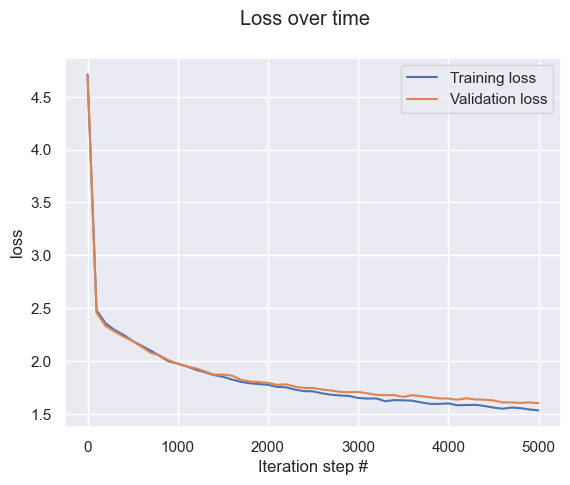

In [15]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_theme()
plt.plot(iter_step, train_loss, label='Training loss')
plt.plot(iter_step, val_loss, label='Validation loss')
plt.legend()
plt.xlabel('Iteration step #')
plt.ylabel('loss')
plt.suptitle('Loss over time')
plt.show()